In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import h5py
import os.path

import image_proc
import train_detector

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from craft.craft import CRAFT

import time
from importlib import reload

In [9]:
reload(train_detector)

<module 'train_detector' from '/home/eee198/Documents/ocr/asstr/train_detector.py'>

In [2]:
gt_path = "/home/eee198/Downloads/SynthText/gt_v7.3.mat"
img_dir = "/home/eee198/Downloads/SynthText/images"

dataset_kwargs = {"cuda": False}
dataloader_kwargs = {"batch_size": 4}

dataloader, train, test = train_detector.init_data(gt_path, img_dir,
        dataset_kwargs=dataset_kwargs, dataloader_kwargs=dataloader_kwargs)

In [3]:
folder_name = "apr9/35407_interrupt"
weight_dir = f"/home/eee198/Downloads/SynthText/weights/{folder_name}"
weight_fname = None
num_class = 3

model, criterion, optimizer = train_detector.init_model(weight_dir, weight_fname, num_class)

In [ ]:
epochs = 1
folder_name = "apr9/35407_interrupt"
weight_dir = f"/home/eee198/Downloads/SynthText/weights/{folder_name}"

retval = train_detector.train_loop(dataloader, model, criterion, optimizer,
                                   weight_dir, epochs=epochs)

[1,   100] loss: 0.022631
[1,   200] loss: 0.019745
[1,   300] loss: 0.022948
[1,   400] loss: 0.021803
[1,   500] loss: 0.022013
[1,   600] loss: 0.024409
[1,   700] loss: 0.019734
[1,   800] loss: 0.019499
[1,   900] loss: 0.024817
[1,  1000] loss: 0.021945
[1,  1100] loss: 0.020605
[1,  1200] loss: 0.020523
[1,  1300] loss: 0.021255
[1,  1400] loss: 0.021937
[1,  1500] loss: 0.024685
[1,  1600] loss: 0.023322
[1,  1700] loss: 0.022912
[1,  1800] loss: 0.023332
[1,  1900] loss: 0.021551
[1,  2000] loss: 0.021580
[1,  2100] loss: 0.023664
[1,  2200] loss: 0.019565
[1,  2300] loss: 0.021719
[1,  2400] loss: 0.023192
[1,  2500] loss: 0.023408
[1,  2600] loss: 0.023392
[1,  2700] loss: 0.022135
[1,  2800] loss: 0.019650
[1,  2900] loss: 0.020570
[1,  3000] loss: 0.024279
[1,  3100] loss: 0.022950
[1,  3200] loss: 0.022609
[1,  3300] loss: 0.022820
[1,  3400] loss: 0.020818
[1,  3500] loss: 0.022178
[1,  3600] loss: 0.022142
[1,  3700] loss: 0.020793
[1,  3800] loss: 0.021905
[1,  3900] l

[1, 31000] loss: 0.023818
[1, 31100] loss: 0.021462
[1, 31200] loss: 0.023252
[1, 31300] loss: 0.023059
[1, 31400] loss: 0.021104
[1, 31500] loss: 0.021178
[1, 31600] loss: 0.021767
[1, 31700] loss: 0.023418
[1, 31800] loss: 0.023110
[1, 31900] loss: 0.020025
[1, 32000] loss: 0.021868
[1, 32100] loss: 0.020595
[1, 32200] loss: 0.021100
[1, 32300] loss: 0.020810
[1, 32400] loss: 0.020891
[1, 32500] loss: 0.023119
[1, 32600] loss: 0.023714
[1, 32700] loss: 0.020815
[1, 32800] loss: 0.022233
[1, 32900] loss: 0.022334
[1, 33000] loss: 0.020572
[1, 33100] loss: 0.021946
[1, 33200] loss: 0.019340
[1, 33300] loss: 0.020458
[1, 33400] loss: 0.023402
[1, 33500] loss: 0.022972
[1, 33600] loss: 0.024216
[1, 33700] loss: 0.020469
[1, 33800] loss: 0.021253
[1, 33900] loss: 0.022681
[1, 34000] loss: 0.022228
[1, 34100] loss: 0.021930
[1, 34200] loss: 0.021594
[1, 34300] loss: 0.022094
[1, 34400] loss: 0.023347
[1, 34500] loss: 0.024183
[1, 34600] loss: 0.022678
[1, 34700] loss: 0.020062
[1, 34800] l

[1, 61900] loss: 0.022192
[1, 62000] loss: 0.021935
[1, 62100] loss: 0.023772
[1, 62200] loss: 0.023209
[1, 62300] loss: 0.027067
[1, 62400] loss: 0.021668
[1, 62500] loss: 0.021120
[1, 62600] loss: 0.023010
[1, 62700] loss: 0.023051
[1, 62800] loss: 0.021197
[1, 62900] loss: 0.022944
[1, 63000] loss: 0.021403
[1, 63100] loss: 0.023204
[1, 63200] loss: 0.022470
[1, 63300] loss: 0.021743
[1, 63400] loss: 0.022999
[1, 63500] loss: 0.020993
[1, 63600] loss: 0.024937
[1, 63700] loss: 0.021283
[1, 63800] loss: 0.023066
[1, 63900] loss: 0.021642
[1, 64000] loss: 0.021552
[1, 64100] loss: 0.024474
[1, 64200] loss: 0.022501
[1, 64300] loss: 0.022122
[1, 64400] loss: 0.019724
[1, 64500] loss: 0.025012
[1, 64600] loss: 0.023731
[1, 64700] loss: 0.022891
[1, 64800] loss: 0.021396
[1, 64900] loss: 0.022664
[1, 65000] loss: 0.021922
[1, 65100] loss: 0.020888
[1, 65200] loss: 0.025400
[1, 65300] loss: 0.023341
[1, 65400] loss: 0.021220
[1, 65500] loss: 0.021958
[1, 65600] loss: 0.024095
[1, 65700] l

[1, 92800] loss: 0.023543
[1, 92900] loss: 0.020335
[1, 93000] loss: 0.021730
[1, 93100] loss: 0.019321
[1, 93200] loss: 0.020790
[1, 93300] loss: 0.018982
[1, 93400] loss: 0.021252
[1, 93500] loss: 0.021634
[1, 93600] loss: 0.023444
[1, 93700] loss: 0.019441
[1, 93800] loss: 0.021254
[1, 93900] loss: 0.018789
[1, 94000] loss: 0.023374
[1, 94100] loss: 0.018858
[1, 94200] loss: 0.022868
[1, 94300] loss: 0.021703
[1, 94400] loss: 0.021714
[1, 94500] loss: 0.019543
[1, 94600] loss: 0.023271
[1, 94700] loss: 0.021647
[1, 94800] loss: 0.023321
[1, 94900] loss: 0.021341
[1, 95000] loss: 0.023276
[1, 95100] loss: 0.020839
[1, 95200] loss: 0.020042
[1, 95300] loss: 0.021145
[1, 95400] loss: 0.020323
[1, 95500] loss: 0.019627
[1, 95600] loss: 0.020465
[1, 95700] loss: 0.022014
[1, 95800] loss: 0.023711
[1, 95900] loss: 0.023170
[1, 96000] loss: 0.021159
[1, 96100] loss: 0.018756
[1, 96200] loss: 0.022387
[1, 96300] loss: 0.020748
[1, 96400] loss: 0.021161
[1, 96500] loss: 0.023597
[1, 96600] l

[1, 122800] loss: 0.023181
[1, 122900] loss: 0.019026
[1, 123000] loss: 0.019056
[1, 123100] loss: 0.021559
[1, 123200] loss: 0.042598
[1, 123300] loss: 0.022865
[1, 123400] loss: 0.021817
[1, 123500] loss: 0.021717
[1, 123600] loss: 0.020131
[1, 123700] loss: 0.019368
[1, 123800] loss: 0.022412
[1, 123900] loss: 0.021909
[1, 124000] loss: 0.019420
[1, 124100] loss: 0.021679
[1, 124200] loss: 0.022552
[1, 124300] loss: 0.021285
[1, 124400] loss: 0.022977
[1, 124500] loss: 0.021917
[1, 124600] loss: 0.021575
[1, 124700] loss: 0.021170
[1, 124800] loss: 0.020561
[1, 124900] loss: 0.021631
[1, 125000] loss: 0.022196
[1, 125100] loss: 0.022523
[1, 125200] loss: 0.021564
[1, 125300] loss: 0.022785
[1, 125400] loss: 0.024466
[1, 125500] loss: 0.022057
[1, 125600] loss: 0.022737
[1, 125700] loss: 0.022677
[1, 125800] loss: 0.022184
[1, 125900] loss: 0.023307
[1, 126000] loss: 0.020798
[1, 126100] loss: 0.020725
[1, 126200] loss: 0.020808
[1, 126300] loss: 0.019859
[1, 126400] loss: 0.021458
[

[1,  7300] loss: 0.020622
[1,  7400] loss: 0.021319
[1,  7500] loss: 0.021829
[1,  7600] loss: 0.022256
[1,  7700] loss: 0.021919
[1,  7800] loss: 0.025377
[1,  7900] loss: 0.020130
[1,  8000] loss: 0.021995
[1,  8100] loss: 0.020949
[1,  8200] loss: 0.021706
[1,  8300] loss: 0.021950
[1,  8400] loss: 0.021228
[1,  8500] loss: 0.021196
[1,  8600] loss: 0.020098
[1,  8700] loss: 0.021206
[1,  8800] loss: 0.022578
[1,  8900] loss: 0.020630
[1,  9000] loss: 0.020723
[1,  9100] loss: 0.019981
[1,  9200] loss: 0.019846
[1,  9300] loss: 0.021861
[1,  9400] loss: 0.022054
[1,  9500] loss: 0.020836
[1,  9600] loss: 0.021223
[1,  9700] loss: 0.021821
[1,  9800] loss: 0.020524
[1,  9900] loss: 0.020118
[1, 10000] loss: 0.020375

saving at 10000-th batch

Elapsed time: 323415.67785573006
[1, 10100] loss: 0.024516
[1, 10200] loss: 0.022437
[1, 10300] loss: 0.023284
[1, 10400] loss: 0.021772
[1, 10500] loss: 0.022546
[1, 10600] loss: 0.019460
[1, 10700] loss: 0.021830
[1, 10800] loss: 0.021295
[1, 

[1, 38200] loss: 0.019921
[1, 38300] loss: 0.021823
[1, 38400] loss: 0.020722
[1, 38500] loss: 0.023098
[1, 38600] loss: 0.021907
[1, 38700] loss: 0.022484
[1, 38800] loss: 0.024366
[1, 38900] loss: 0.023542
[1, 39000] loss: 0.019124
[1, 39100] loss: 0.021133
[1, 39200] loss: 0.023954
[1, 39300] loss: 0.020424
[1, 39400] loss: 0.019529
[1, 39500] loss: 0.020137
[1, 39600] loss: 0.024714
[1, 39700] loss: 0.021102
[1, 39800] loss: 0.018838
[1, 39900] loss: 0.022504
[1, 40000] loss: 0.019232

saving at 40000-th batch

Elapsed time: 385949.2924823761
[1, 40100] loss: 0.022477
[1, 40200] loss: 0.022217
[1, 40300] loss: 0.022004
[1, 40400] loss: 0.023630
[1, 40500] loss: 0.021099
[1, 40600] loss: 0.022572
[1, 40700] loss: 0.020371
[1, 40800] loss: 0.021819
[1, 40900] loss: 0.019816
[1, 41000] loss: 0.023005
[1, 41100] loss: 0.020793
[1, 41200] loss: 0.022036
[1, 41300] loss: 0.019750
[1, 41400] loss: 0.022125
[1, 41500] loss: 0.021276
[1, 41600] loss: 0.022900
[1, 41700] loss: 0.020685
[1, 4

[1, 11100] loss: 0.020635
[1, 11200] loss: 0.021838
[1, 11300] loss: 0.022350
[1, 11400] loss: 0.021566
[1, 11500] loss: 0.022551
[1, 11600] loss: 0.019997
[1, 11700] loss: 0.019685
[1, 11800] loss: 0.021606
[1, 11900] loss: 0.021195
[1, 12000] loss: 0.021073
[1, 12100] loss: 0.020654
[1, 12200] loss: 0.020622
[1, 12300] loss: 0.021306
[1, 12400] loss: 0.020300
[1, 12500] loss: 0.020761
[1, 12600] loss: 0.020700
[1, 12700] loss: 0.020228
[1, 12800] loss: 0.020901
[1, 12900] loss: 0.020198
[1, 13000] loss: 0.021586
[1, 13100] loss: 0.024694
[1, 13200] loss: 0.021302
[1, 13300] loss: 0.021606
[1, 13400] loss: 0.021900
[1, 13500] loss: 0.019619
[1, 13600] loss: 0.021687
[1, 13700] loss: 0.021303
[1, 13800] loss: 0.023782
[1, 13900] loss: 0.019952
[1, 14000] loss: 0.019327
[1, 14100] loss: 0.021418
[1, 14200] loss: 0.021407
[1, 14300] loss: 0.020806
[1, 14400] loss: 0.021506
[1, 14500] loss: 0.020575
[1, 14600] loss: 0.021072
[1, 14700] loss: 0.021733
[1, 14800] loss: 0.020547
[1, 14900] l

[1, 42000] loss: 0.021947
[1, 42100] loss: 0.020499
[1, 42200] loss: 0.024113
[1, 42300] loss: 0.021466
[1, 42400] loss: 0.022209
[1, 42500] loss: 0.022983
[1, 42600] loss: 0.021686
[1, 42700] loss: 0.018514
[1, 42800] loss: 0.021277
[1, 42900] loss: 0.024314
[1, 43000] loss: 0.020780
[1, 43100] loss: 0.021919
[1, 43200] loss: 0.020027
[1, 43300] loss: 0.019099
[1, 43400] loss: 0.020520
[1, 43500] loss: 0.023583
[1, 43600] loss: 0.020197
[1, 43700] loss: 0.018876
[1, 43800] loss: 0.019432
[1, 43900] loss: 0.019657
[1, 44000] loss: 0.022630
[1, 44100] loss: 0.021351
[1, 44200] loss: 0.020944
[1, 44300] loss: 0.021336
[1, 44400] loss: 0.020704
[1, 44500] loss: 0.021531
[1, 44600] loss: 0.022399
[1, 44700] loss: 0.022036
[1, 44800] loss: 0.021507
[1, 44900] loss: 0.025380
[1, 45000] loss: 0.020915
[1, 45100] loss: 0.019980
[1, 45200] loss: 0.020579
[1, 45300] loss: 0.023540
[1, 45400] loss: 0.020265
[1, 45500] loss: 0.021906
[1, 45600] loss: 0.022102
[1, 45700] loss: 0.021785
[1, 45800] l

[1, 25700] loss: 0.020285
[1, 25800] loss: 0.018424
[1, 25900] loss: 0.019624
[1, 26000] loss: 0.020965
[1, 26100] loss: 0.022133
[1, 26200] loss: 0.018265
[1, 26300] loss: 0.020342
[1, 26400] loss: 0.019808
[1, 26500] loss: 0.022091
[1, 26600] loss: 0.019771
[1, 26700] loss: 0.022082
[1, 26800] loss: 0.021176
[1, 26900] loss: 0.021086
[1, 27000] loss: 0.022964
[1, 27100] loss: 0.016625
[1, 27200] loss: 0.019301
[1, 27300] loss: 0.021219
[1, 27400] loss: 0.018388
[1, 27500] loss: 0.021750
[1, 27600] loss: 0.019247
[1, 27700] loss: 0.019984
[1, 27800] loss: 0.020067
[1, 27900] loss: 0.023495
[1, 28000] loss: 0.021234
[1, 28100] loss: 0.020658
[1, 28200] loss: 0.022079
[1, 28300] loss: 0.019111
[1, 28400] loss: 0.021195
[1, 28500] loss: 0.019896
[1, 28600] loss: 0.031078
[1, 28700] loss: 0.020935
[1, 28800] loss: 0.020859
[1, 28900] loss: 0.024493
[1, 29000] loss: 0.019489
[1, 29100] loss: 0.021906
[1, 29200] loss: 0.019841
[1, 29300] loss: 0.021765
[1, 29400] loss: 0.019465
[1, 29500] l

[1, 56600] loss: 0.021380
[1, 56700] loss: 0.021582
[1, 56800] loss: 0.020985
[1, 56900] loss: 0.020474
[1, 57000] loss: 0.022984
[1, 57100] loss: 0.020298
[1, 57200] loss: 0.019043
[1, 57300] loss: 0.022940
[1, 57400] loss: 0.020611
[1, 57500] loss: 0.021353
[1, 57600] loss: 0.020352
[1, 57700] loss: 0.020408
[1, 57800] loss: 0.019796
[1, 57900] loss: 0.024346
[1, 58000] loss: 0.023006
[1, 58100] loss: 0.020698
[1, 58200] loss: 0.022549
[1, 58300] loss: 0.020218
[1, 58400] loss: 0.021715
[1, 58500] loss: 0.020037
[1, 58600] loss: 0.017894
[1, 58700] loss: 0.022843


In [29]:
for img,gt in dataloader:
    print(f"img.shape = {img.shape}")
    print(f"gt.shape = {gt.shape}")
#     print(f"hard_img.shape = {hard_img.shape}")
#     print(f"hard_gt.shape = {hard_gt.shape}")
    break

dir_maps = gt[0].permute(2,0,1)
print(dir_maps.shape)
print(torch.max(dir_maps[2]))
print(torch.min(dir_maps[2]))

img.shape = torch.Size([4, 3, 354, 441])
gt.shape = torch.Size([4, 177, 220, 3])
torch.Size([3, 177, 220])
tensor(1.0253, device='cuda:0')
tensor(-0.9895, device='cuda:0')


In [6]:
model = CRAFT(pretrained=True, num_class=3).cuda()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001) # tweak parameters

In [16]:
reload(train_detector)

<module 'train_detector' from '/home/eee198/Documents/ocr/asstr/train_detector.py'>

In [17]:
train_detector.train_loop(dataloader, model, criterion, optimizer, weight_dir, overfit=True)

[1,   100] loss: 0.126285
[1,   200] loss: 0.095238
[1,   300] loss: 0.070658
[1,   400] loss: 0.053404
[1,   500] loss: 0.042090
[1,   600] loss: 0.034786
[1,   700] loss: 0.030010
[1,   800] loss: 0.026800
[1,   900] loss: 0.024569
[1,  1000] loss: 0.022966
[1,  1100] loss: 0.021777
[1,  1200] loss: 0.020872
[1,  1300] loss: 0.020165
[1,  1400] loss: 0.019601
[1,  1500] loss: 0.019143
[1,  1600] loss: 0.018767
[1,  1700] loss: 0.018451
[1,  1800] loss: 0.018184
[1,  1900] loss: 0.017954
[1,  2000] loss: 0.017755
[1,  2100] loss: 0.017582
[1,  2200] loss: 0.017429
[1,  2300] loss: 0.017294
[1,  2400] loss: 0.017172
[1,  2500] loss: 0.017062
[1,  2600] loss: 0.016963
[1,  2700] loss: 0.016872
[1,  2800] loss: 0.016790
[1,  2900] loss: 0.016714
[1,  3000] loss: 0.016643
[1,  3100] loss: 0.016578
[1,  3200] loss: 0.016517

Saving at 3288-th batch...


FileNotFoundError: [Errno 2] No such file or directory: '/home/eee198/Downloads/SynthText/weights/apr6/w_3288_interrupt.pth'

In [9]:
# folder_name = "[3-09-20]_gauss_template"
print(f"folder_name: {folder_name}")

T_save = 10000
T = 1000
epochs = 1
start = time.time()

for epoch in range(epochs):
    running_loss = 0.0

    while(True):
        try:
            for i, (img, target, hard_img, hard_target) in enumerate(dataloader):
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                output, _ = model(img.cuda())
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % T == T-1:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %f' % (epoch + 1, i + 1, running_loss/T))
                    running_loss = 0.0

                ## Hard Example Training
                if (hard_img is not None) and (hard_target is not None):
                    #for hard_img, hard_target in zip(hard_imgs, hard_targets):
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    output, _ = model(hard_img)
                    output[:,:,:,-2:] = (np.clip(output[:,:,:,-2:],-1,1) + 1)/2
                    loss = criterion(output, hard_target)
                    loss.backward()
                    optimizer.step()

                    # print statistics
                    running_loss += loss.item()
                    if i % T == T-1:    # print every 2000 mini-batches
                        print('\t[%d, %5d] loss: %f' % (epoch + 1, i + 1, running_loss/T))
                        running_loss = 0.0



                if i % T_save == T_save-1:
                    print(f"\nsaving at {i}-th batch'\n")
                    torch.save(model.state_dict(), f"/home/eee198/Downloads/SynthText/weights/{folder_name}/w_{i}.pth")
                    end = time.time()
                    print(f"\nElapsed time: {end-start}")
                print(i, end='')
            break
        except MemoryError:
            print("Memory Error")
            continue
        except AttributeError:
            print("Attribute Error")
        except KeyboardInterrupt:
            print(f"\nsaving at {i}-th batch'\n")
            torch.save(model.state_dict(), f"/home/eee198/Downloads/SynthText/weights/{folder_name}/w_{i}_interrupt.pth")
            end = time.time()
            print(f"\nElapsed time: {end-start}")
            
            break
        except Exception as e:
            print(e)
            continue


print("Finished training.")

end = time.time()
print(f"\nTotal elapsed time: {end-start}")

folder_name: apr1
0123456789101112131415161718192021222324252627
saving at 27-th batch'



FileNotFoundError: [Errno 2] No such file or directory: '/home/eee198/Downloads/SynthText/weights/apr1/w_27_interrupt.pth'

In [6]:
torch.save(model.state_dict(), f"/home/eee198/Downloads/SynthText/weights/{folder_name}/w_{i}_interrupt.pth")

In [7]:
model.load_state_dict(torch.load(pth_path))
model.eval()

CRAFT(
  (basenet): vgg16_bn(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (slice2): Sequential(
      (12): ReLU(inplace)
      (13): MaxPool2d(kernel_size=2, stride=2, 

In [4]:
for img, gt, hard_img, hard_gt in dataloader:
    print(f"img.shape = {img.shape}")
    print(f"img.shape = {gt.shape}")
    print(f"img.shape = {hard_img.shape}")
    print(f"img.shape = {hard_gt.shape}")
    break

img.shape = torch.Size([4, 3, 768, 768])
img.shape = torch.Size([4, 768, 768, 3])
img.shape = torch.Size([15, 3, 104, 300])
img.shape = torch.Size([15, 52, 150, 3])


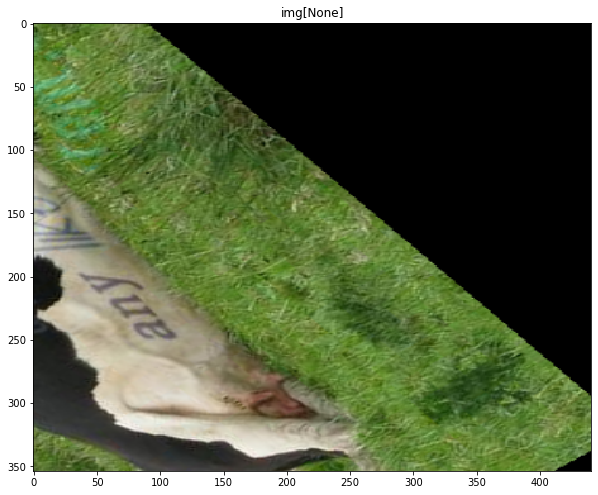

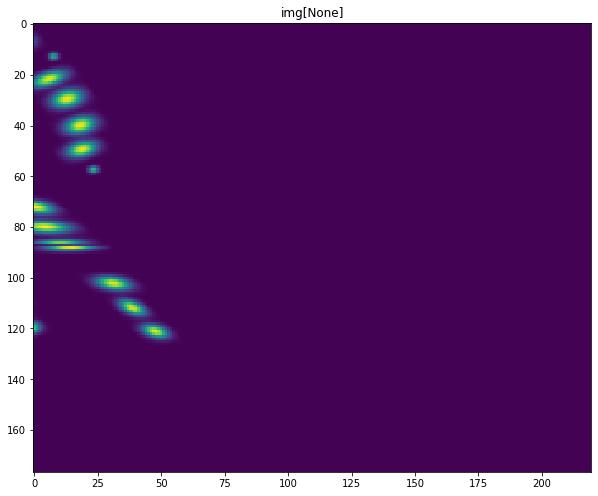

NameError: name 'hard_img' is not defined

In [30]:
def show_samples(imgs, i=None, feature_type="img", title=None, channel=None):
    imgs = imgs.detach().cpu().numpy()
    if i == None:
        img = imgs
    else:
        img = imgs[i]

    if feature_type == "img":
        img = img.transpose(1,2,0)
    elif feature_type == "gt":
        pass

    if channel != None:
        img = img[:,:,channel]
        
    if title is None:
        title = f"img[{i}]"

    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.imshow(img, interpolation='nearest')

    plt.show()

i = 2
show_samples(img[i])
show_samples(gt[i], feature_type="gt", channel=0)
show_samples(hard_img[i])
show_samples(hard_gt[i], feature_type="gt", channel=0)

In [31]:
output, _ = model(img.cuda())
print(f"output.shape = {output.shape}")

output.shape = torch.Size([4, 177, 220, 3])


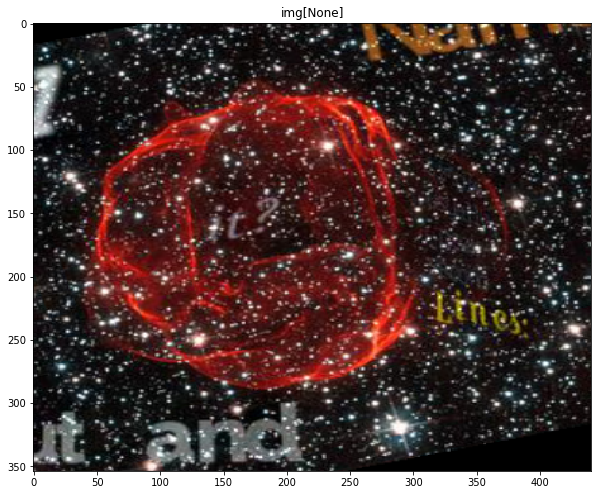

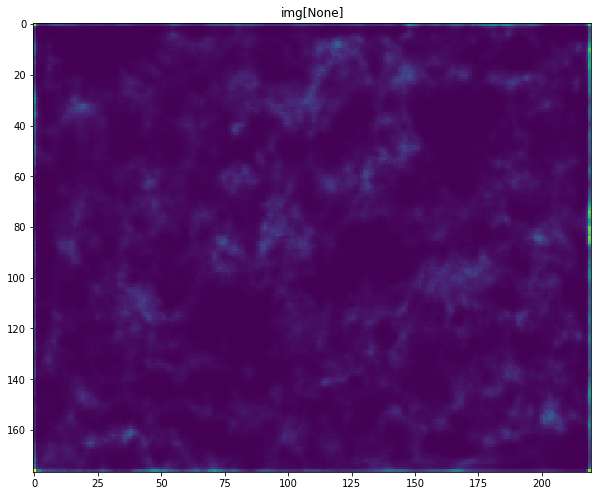

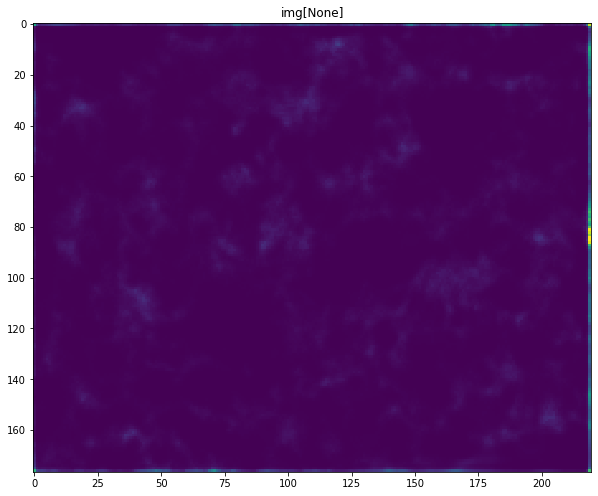

In [35]:
i = 3
show_samples(img[i])
show_samples(output[i], feature_type="gt", channel=0)
show_samples(output[i], feature_type="gt", channel=1)